<a href="https://colab.research.google.com/github/CristianCosci/Generative_Adversarial_Networks_GAN__Overview/blob/master/DCGAN/notebooks/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.utils import make_grid

import numpy as np
import datetime
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from tqdm import tqdm
import glob
from PIL import Image

### **Google Drive linking and other operations for saving some data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH_DRIVE = '/content/drive/My Drive/UNIMORE/DCGAN' # Path on Google Drive where to save data (trained models and generation samples)

Mounted at /content/drive


In [3]:
verbose = False
torch.manual_seed(1)
NOISE_VECTOR_DIM = 100
MODEL_NAME = 'DeepConvolutionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(PATH_DRIVE + '/samples'):
  os.makedirs(PATH_DRIVE + '/samples')

if not os.path.exists(PATH_DRIVE + '/samples/gif_dir'):
  os.makedirs(PATH_DRIVE + '/samples/gif_dir')

if not os.path.exists(PATH_DRIVE + '/training_models'):
  os.makedirs(PATH_DRIVE + '/training_models')

if not os.path.exists(PATH_DRIVE + '/training_models/Discriminator'):
  os.makedirs(PATH_DRIVE + '/training_models/Discriminator')

if not os.path.exists(PATH_DRIVE + '/training_models/Generator'):
  os.makedirs(PATH_DRIVE + '/training_models/Generator')

if not os.path.exists('dataset'):
  os.makedirs('dataset')

In [ ]:
dataset_path = PATH_DRIVE + "/anime_dataset/archive.zip"
print(dataset_path)
!unzip '/content/drive/My Drive/UNIMORE/DCGAN/anime_dataset/archive.zip' -d 'dataset/'  #unzipping dataset

# **Project start**

In [5]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [6]:
def get_sample_images(G, num_samples):
  '''
  Generate num_samples noise vector from latent space and pass to Generator
  as input in order to get sample images.

  returns:
    num_samples generate images
  '''
  samples_per_line = int(np.sqrt(num_samples))
  matrix_img = np.zeros([28 * samples_per_line, 28 * samples_per_line])
  #img = np.zeros([280, 280])
  for j in range(10):
    c = torch.zeros([10, 10]).to(DEVICE)
    c[:, j] = 1
    z = torch.randn(samples_per_line, NOISE_VECTOR_DIM).to(DEVICE)
    y_hat = G(z,c).view(samples_per_line, 28, 28)
    result = y_hat.cpu().data.numpy()
    matrix_img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
  return matrix_img
    

def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.title('epoch: {}'.format(int(i* 150/len(imgs))))
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i* 150/len(imgs)))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save(PATH_DRIVE + "/training_improvements.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)

In [7]:
def show_images(images):
  fig, ax = plt.subplots(figsize=(20, 20))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
  for images, _ in dl:
    show_images(images)
    break

### **Dataset loading and preparation**

In [8]:
train_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_dataset = datasets.ImageFolder(root='dataset', transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

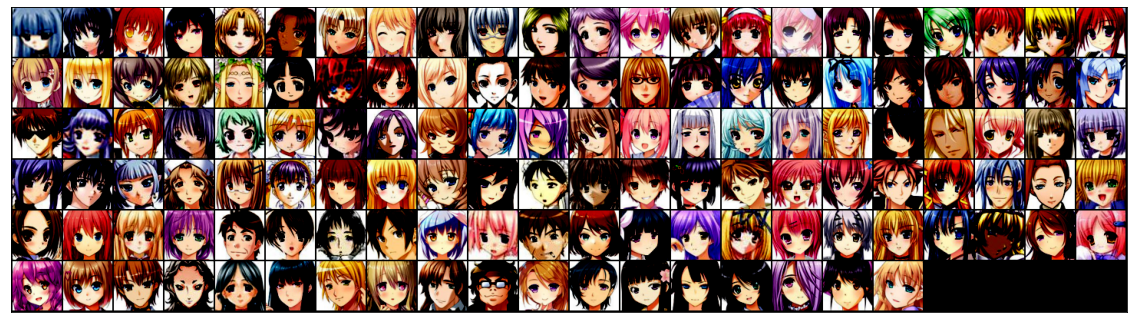

In [9]:
show_batch(train_loader)

In [ ]:
# Generator Model Class Definition      
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # Block 2: (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # Block 3: (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # Block 4: (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 5: (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (3) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output    

In [ ]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, input):
        output = self.main(input)
        return output

## **Training phase**

In [ ]:
#Models creation
num_samples = 100
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#Loss function
adversarial_loss  = nn.BCELoss()

#Optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
num_epochs = 2
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
      
        real_target = Variable(torch.ones(real_images.size(0)).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0)).to(device))
        
        real_target = real_target.unsqueeze(1)
        fake_target = fake_target.unsqueeze(1)

        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        # print(discriminator(real_images))
        D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)  
        noise_vector = noise_vector.to(device)
    
        generated_image = generator(noise_vector)
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        D_fake_loss.backward()
      
        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss)
      
        #D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], 'dcgan/torch/images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), 'dcgan/torch/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), 'dcgan/torch/training_weights/discriminator_epoch_%d.pth' % (epoch))

## **Post training operations**

### **Plotting Generator and Discriminator's losses**

In [ ]:
plt.figure(figsize=(15,9)) 
plt.plot(D_loss_history, color='blue', label='D_loss') #plot the data
plt.plot(G_loss_history, color='orange', label='G_loss') #plot the data
plt.ylabel('loss value') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("G_loss vs D_loss") #set the title of the graph
plt.legend()
plt.show() #display the graph

### **Plotting some sample images**

In [ ]:
# generation to image
G.eval()
plt.figure(figsize=(8,8)) 
imshow(get_sample_images(G, num_samples), cmap='gray')

In [ ]:
# Saving params
min_value = min(G_loss_history)
min_index = G_loss_history.index(min_value)
print(min_index)  #to see at which epoch the Generator has te lowest loss

# Saving models at last epoch of training
torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/Discriminator.pth')
torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/Generator.pth')

### **Loading model using pytorch**

In [ ]:
G.load_state_dict(torch.load(PATH_DRIVE + '/training_models/Generator/G_epoch_149.pth'), strict=False)
G.eval()

### **Making a gif to see Generator's improvement during training**

In [ ]:
make_gif(PATH_DRIVE + '/samples/', 300)